<a href="https://colab.research.google.com/github/LoguPrasanth-hub/Anomaly-Detection/blob/main/Detecting_Anomalies_in_Cement_Plant_Sensor_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting Anomalies in Cement Plant Sensor Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings=warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_excel("cyclone preheater.xlsx")
df.head()

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.9
1,2017-01-01 00:05:00,879.23,918.14,-184.33,-182.1,862.53,-149.76
2,2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
3,2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
4,2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


In [ ]:
df=df.copy()

In [ ]:
df.isnull().sum()

,0
time,0
Cyclone_Inlet_Gas_Temp,0
Cyclone_Material_Temp,0
Cyclone_Outlet_Gas_draft,0
Cyclone_cone_draft,0
Cyclone_Gas_Outlet_Temp,0
Cyclone_Inlet_Draft,0


In [ ]:
for col in df.columns[1:]:
  df[col]=pd.to_numeric(df[col],errors='coerce')

df.isnull().sum()

,0
time,0
Cyclone_Inlet_Gas_Temp,1320
Cyclone_Material_Temp,1591
Cyclone_Outlet_Gas_draft,1321
Cyclone_cone_draft,1320
Cyclone_Gas_Outlet_Temp,1321
Cyclone_Inlet_Draft,1322


In [ ]:
df=df.dropna()

In [ ]:
features=df.iloc[:,1:]
features.head()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,867.63,910.42,-189.54,-186.04,852.13,-145.90
1,879.23,918.14,-184.33,-182.10,862.53,-149.76
2,875.67,924.18,-181.26,-166.47,866.06,-145.01
3,875.28,923.15,-179.15,-174.83,865.85,-142.82
4,891.66,934.26,-178.32,-173.72,876.06,-143.39


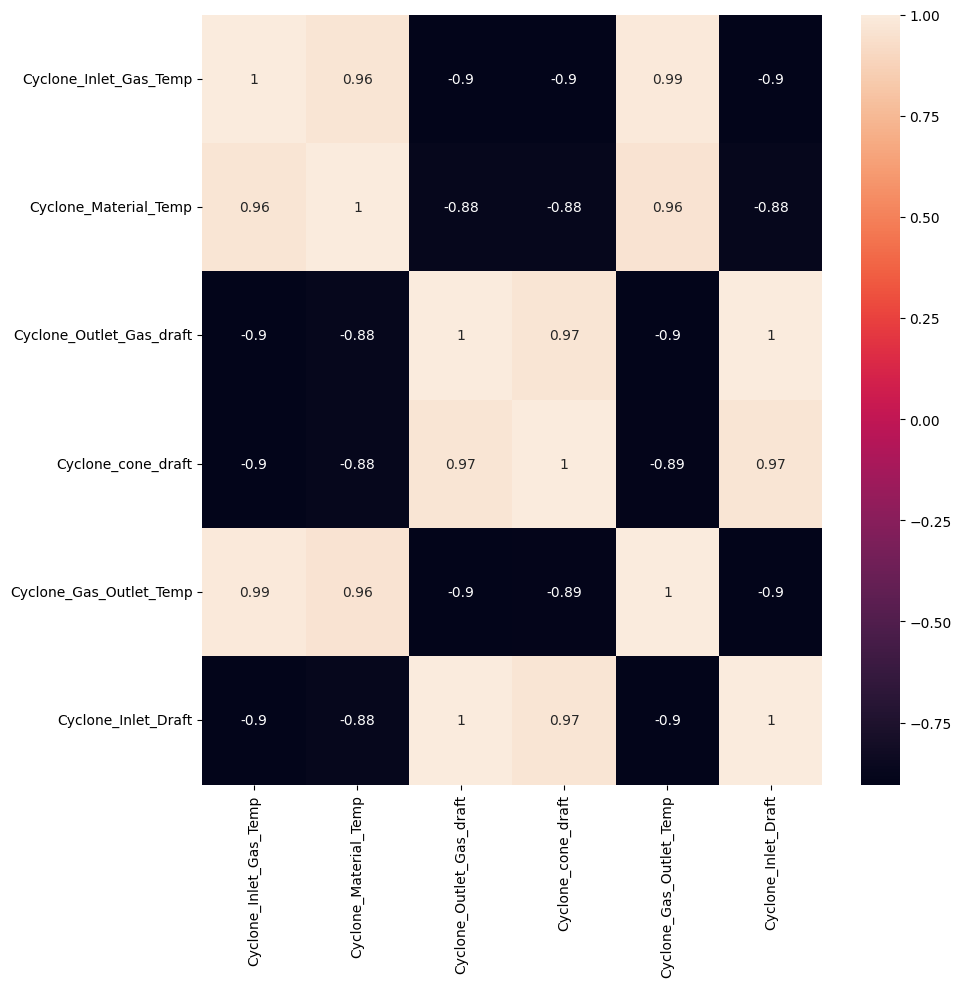

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(features.corr(),annot=True)
plt.show()

**ISOLATION FOREST**

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.inspection import permutation_importance

In [ ]:
iso_forest=IsolationForest()

In [ ]:
param_grid={
    "n_estimators" : [100,200,300],
    "max_samples" : ["auto",0.7,0.9],
    "contamination" : [0.02,0.05,0.1],
    "random_state" : [42]
}

In [ ]:
def silhouette_score(model,x):
  anomaly_scores=model.decision_function(x)  # get anomaly scores
  return silhouette_score(x, anomaly_scores)  # compare normal vs. anomaly separation

In [ ]:
grid_search=GridSearchCV(iso_forest, param_grid, scoring=silhouette_score, cv=3, n_jobs=-1)
grid_search.fit(features)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3, estimator=IsolationForest(), n_jobs=-1,
             param_grid={'contamination': [0.02, 0.05, 0.1],
                         'max_samples': ['auto', 0.7, 0.9],
                         'n_estimators': [100, 200, 300],
                         'random_state': [42]},
             scoring=<function silhouette_score at 0x786e384c1760>)

In [ ]:
best_model=grid_search.best_estimator_
print("Best Parameters : ",grid_search.best_params_)

Best Parameters :  {'contamination': 0.02, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}


In [ ]:
best_model

IsolationForest(contamination=0.02, random_state=42)

In [ ]:
iso_forest=IsolationForest(contamination=0.02,max_samples='auto',n_estimators=100,random_state=42)
iso_forest=iso_forest.fit_predict(features)
iso_forest

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
df['anomaly_score']=iso_forest
df['anomaly_score'].head()

,anomaly_score
0,1
1,1
2,1
3,1
4,1


In [ ]:
print("Anomalies found : ", sum(df['anomaly_score']==-1))

Anomalies found :  7523


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


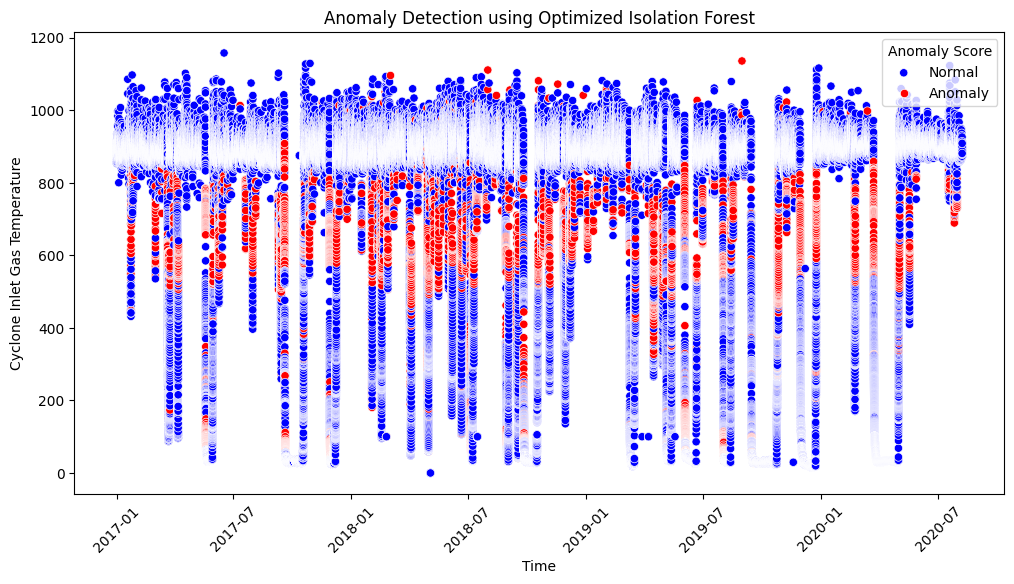

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=df['time'],y=df['Cyclone_Inlet_Gas_Temp'], hue=df['anomaly_score'], palette={1 : "blue", -1 : "red"})
plt.xlabel('Time')
plt.ylabel("Cyclone Inlet Gas Temperature")
plt.title("Anomaly Detection using Optimized Isolation Forest")
plt.legend(title="Anomaly Score",labels=['Normal','Anomaly'])
plt.xticks(rotation=45)
plt.show()

**FEATURE IMPORTANCE**

In [ ]:
iso_forest=IsolationForest(contamination=0.02,max_samples='auto',n_estimators=100,random_state=42)
iso_forest=iso_forest.fit(features)
iso_scores = iso_forest.decision_function(features)

In [ ]:
# Define a custom scoring function for permutation importance
def custom_scorer(model, X,y=None):
    return silhouette_score(X, model.predict(X))

# Compute Permutation Importance using anomaly scores
perm_importance = permutation_importance(iso_forest, features, iso_scores, n_repeats=10, random_state=42, scoring=custom_scorer)

# Convert results into a DataFrame
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

KeyboardInterrupt: 

In [ ]:
# Print feature importance values
print(importance_df)

In [ ]:
# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Permutation Importance of Features (Isolation Forest)")
plt.xlabel("Mean Importance Score")
plt.ylabel("Feature")
plt.show()

**AUTOENCODERS**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler=MinMaxScaler()
scaled_features=scaler.fit_transform(features)

In [ ]:
input_dim=scaled_features.shape[1]
encoding_dim=4

In [ ]:
input_layer=Input(shape=(input_dim,))
encoded=Dense(encoding_dim, activation='relu')(input_layer)
decoded=Dense(input_dim, activation='sigmoid')(encoded)

In [ ]:
autoencoder=Model(input_layer,decoded)
autoencoder.compile(optimizer='adam',loss='mse')

In [ ]:
autoencoder.fit(scaled_features,scaled_features,epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0283 - val_loss: 0.0013
Epoch 2/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0015 - val_loss: 6.0653e-04
Epoch 3/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0010 - val_loss: 4.6319e-04
Epoch 4/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.4753e-04 - val_loss: 4.1008e-04
Epoch 5/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.2377e-04 - val_loss: 3.3505e-04
Epoch 6/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.2974e-04 - val_loss: 2.4300e-04
Epoch 7/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.4346e-04 - val_loss: 2.0645e-04
Epoch 8/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.8111e-04 - val_loss: 1.9817e-04
Epoch 9/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.6381e-04 - val_loss: 1.8858e-04
Epoch 10/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5709e-04 - val_loss: 1.8443e-04
Epoch 11/50
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step 

In [ ]:
reconstructed=autoencoder.predict(scaled_features)
mse=np.mean(np.power(scaled_features-reconstructed,2),axis=1) # top 5% as anomalies

11754/11754 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


In [ ]:
threshold = np.percentile(mse,95)
df['anomaly_score_autoencoder']=(mse>threshold).astype(int)

In [ ]:
autoencoder_mse=(mse>threshold).astype(int)
autoencoder_mse

array([0, 0, 0, ..., 0, 0, 0])

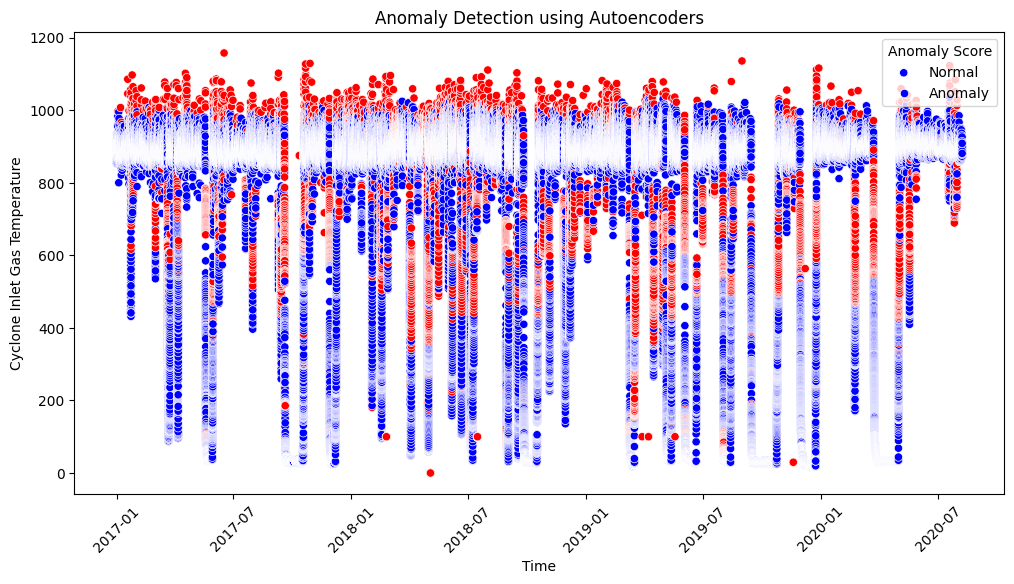

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["time"], y=df["Cyclone_Inlet_Gas_Temp"], hue=df["anomaly_score_autoencoder"], palette={0: "blue", 1: "red"})
plt.xlabel("Time")
plt.ylabel("Cyclone Inlet Gas Temperature")
plt.title("Anomaly Detection using Autoencoders")
plt.legend(title="Anomaly Score", labels=["Normal", "Anomaly"])
plt.xticks(rotation=45)
plt.show()

In [ ]:
iso_score=best_model.decision_function(features)
iso_score

array([0.27725183, 0.27876144, 0.26466176, ..., 0.28788754, 0.2860063 ,
       0.29229976])

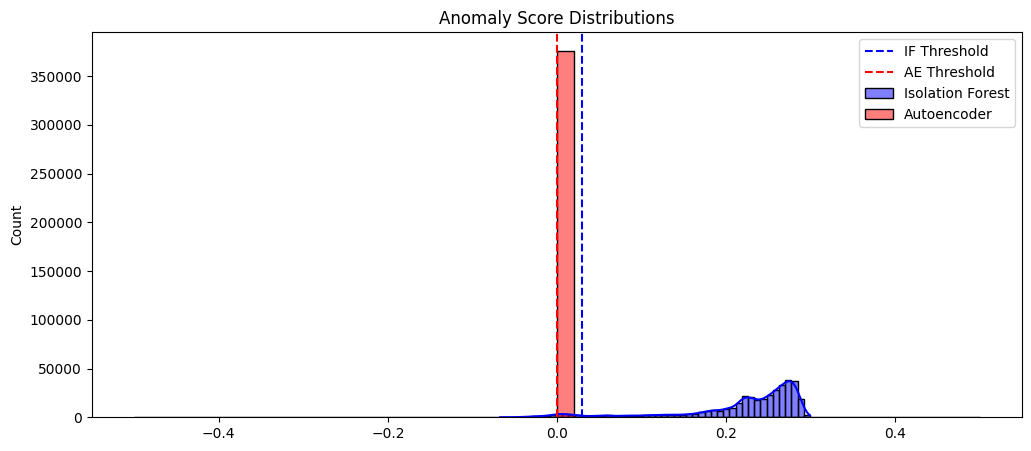

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(iso_score, bins=50, kde=True, color="blue", label="Isolation Forest")
sns.histplot(autoencoder_mse, bins=50, kde=True, color="red", label="Autoencoder")
plt.axvline(np.percentile(iso_score, 5), color="blue", linestyle="dashed", label="IF Threshold")
plt.axvline(np.percentile(autoencoder_mse, 95), color="red", linestyle="dashed", label="AE Threshold")
plt.title("Anomaly Score Distributions")
plt.legend()
plt.show()

**Possible Reasons for Anomalies :**

Pressure fluctuations in drafts could indicate blockages, leaks, or fan malfunctions.

Temperature fluctuations may be secondary effects, impacted by the draft changes.